In [ ]:
% pip install tqdm

In [2]:
import pandas as pd
import os
import re
from tqdm.notebook import tqdm

In [9]:
def preprocess_string(string : str) -> str:
    string = string.lower().strip()
    string = re.sub(' +', ' ', string)
    string = string.replace("_", " ")
    string = string.replace("-", " ")
    string = string.replace("&", " ")
    string = string.split("(")[0]
    string = string.split("#")[0]

    string = string.strip()

    # handle known synoynms
    synonyms = {
        "refrigerator": "fridge",
        "vaccumcleaner": "vacuum cleaner",
        "breadmaker": "bread maker",
      
        
    }
    if string in synonyms:
        string = synonyms[string]
    if "coffeemaker" in string:
        string = "coffee machine"
    if 'hi fi' in string:
        string = "audio system"

    if "router" in string:
        string = "router"

    if "treadmill" in string:
        string = "running machine"
        

    if "laptop" in string:
        string = "laptop"
    
    if "server" in string:
        string = "server"

    if "monitor" in string and not "baby" in string:
        string = "monitor"
    # special cases
    if "computer" in string and "charger" not in string:
        string = "pc"

    if "tv" in string:
        string = "television"

    if "television" in string:
        string = "television"

    if "macbook" in string:
        string = "laptop"
        
    if "car charger" == string:
        string = "ev"
    
    if "toast" in string:
        string = "toaster"
    
    if "modem" in string:
        string = "router"

    # we treat all audio devices as speakers so subwoofer is also a speaker
    if "subwoofer" in string:
        string = "speaker"

    if "speaker" in string:
        string = "speaker"

    if "iron" in string and "soldering" not in string:
        string = "iron"

    
    if "coffeemachine" in string:
        string = "coffee machine"
        
    if "coffee maker" in string:
        string = "coffee machine"

    if "dishwasher" in string:
        string = "dish washer"
    if "air conditioner" in string:
        string = "ac"

    if "air conditioning" in string:
        string = "ac"

    if "waterkettle" in string:
        string = "kettle"
    
    if "washingmachine" in string:
        string = "washing machine"
    if "charger smartphone" in string:
        string = "mobile phone charger"

    if "stove" in string:
        string = "stove"

    if "microwaveoven" in string:
        string = "combination microwave"
    
    if "playstation" in string:
        string = "games console"

    if "projector" in string:
        string = "projector"
    if "desktop" in string:
        string = "pc"
    if "amplifier" in string:
        string = "audio amplifier"
    if "vacuumcleaner" in string:
        string = "vacuum cleaner"
    if "usbhub" in string:
        string = "usb hub"
    if "laundrydryer" in string:
        string = "dryer"
    if "waterboiler" in string:
        string = "kettle"
    
    string = re.sub(' +', ' ', string)
    string = re.sub(r'\d+', '', string)
    return string.strip()

# watts to kWh given data frequency as a fraction of an hour (e.g. 0.5 for half-hourly data)
def watts2kwh(df, data_frequency):
    df = df/1000 * data_frequency
    return df

def preprocess_dataframe(name: str, path: str) -> pd.DataFrame:
    df = pd.read_csv(path, header=None,  sep=";")
    df.drop(columns=[2], inplace=True)
    df.columns = ["time", name]
    try:
        df["time"] = pd.to_datetime(df["time"], format="%d/%m/%Y %H:%M:%S")
    except:
        print(name, "failed to parse dates")
        print(path)
    df.set_index("time", inplace=True)
    df.sort_index(inplace=True)
    df = df[~df.index.duplicated(keep='first')]


    df.resample("8s").fillna(method="nearest", limit=2)
    df = watts2kwh(df, 8/3600)

    time_window = 2700
    # split into 6h windows
    windows = []
    for i in range(0, len(df) - time_window, time_window + 1):
        window = df.iloc[i:i + time_window].copy()
        if window.max().max() == 0:
            print("Device is off for entire window", name)
            continue
        window.reset_index(inplace=True, drop=True)
        windows.append(window)    
    return windows



In [10]:
path = "./Energy_graph/data/tracebase/complete/"
labels = pd.read_pickle("./Energy_graph/labeles.pkl")
os.listdir(path)
ignore = [
    "EthernetSwitch",
    "RemoteDesktop",
    "Alarmclock",
    "WaterFountain",
    "USBHarddrive",
    "CdPlayer",
    "DigitalTvReceiver",
    "Breadcutter",
    "Charger-PSP",
    "XmasLights",
    "Lamp",
    "DvdPlayer",
    "Multimediacenter",
    "SolarThermalSystem",
    "DVD_player"
]

data = {}
for d in tqdm(os.listdir(path)):
    if d in ignore:
        continue 
    name = preprocess_string(d)
    data[name] = []
    for f in os.listdir(path + d):

        if f.endswith(".csv"):

            df = preprocess_dataframe(name, path + d + "/" + f)
            data[name].extend(df)



            

  0%|          | 0/43 [00:00<?, ?it/s]

Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is off for entire window television
Device is o

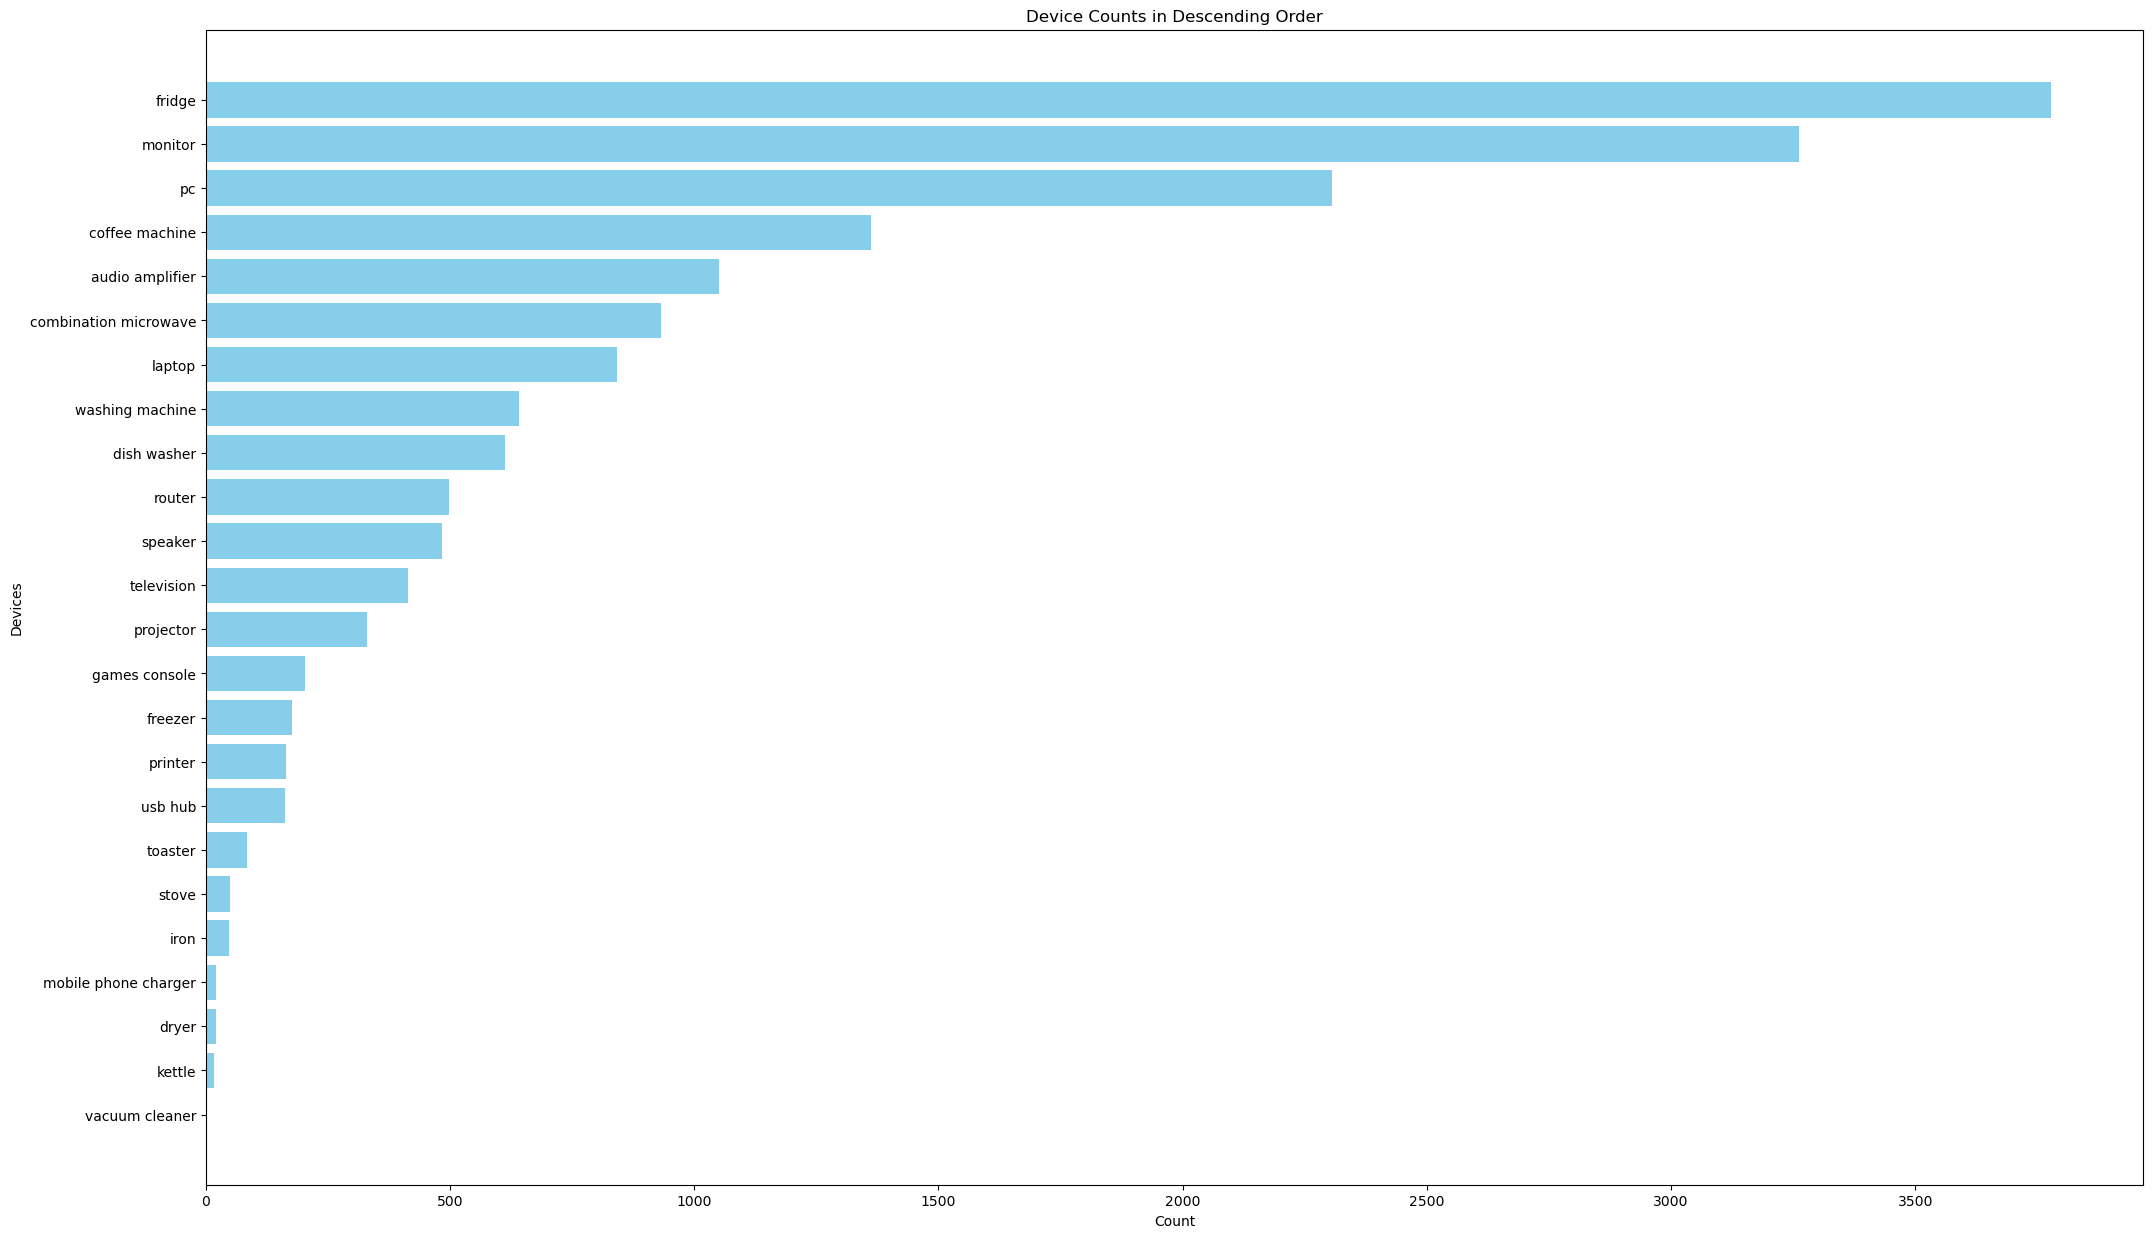

In [11]:
import matplotlib.pyplot as plt

# Extract device names and their lengths
device_names = list(data.keys())
lengths = [len(data[device]) for device in device_names]

# Sort them based on lengths in descending order
sorted_indices = sorted(range(len(lengths)), key=lambda k: lengths[k], reverse=True)
sorted_device_names = [device_names[i] for i in sorted_indices]
sorted_lengths = [lengths[i] for i in sorted_indices]

plt.figure(figsize=(25, 15))
# Plotting
plt.barh(sorted_device_names, sorted_lengths, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Devices')
plt.title('Device Counts in Descending Order')
plt.gca().invert_yaxis()  # This is to have the device with the highest count at the top
plt.show()


In [12]:
for i in range(len(sorted_device_names)):
    print(sorted_device_names[i], sorted_lengths[i])

fridge 3778
monitor 3263
pc 2306
coffee machine 1363
audio amplifier 1050
combination microwave 933
laptop 842
washing machine 642
dish washer 613
router 497
speaker 483
television 415
projector 331
games console 203
freezer 177
printer 164
usb hub 163
toaster 84
stove 50
iron 47
mobile phone charger 20
dryer 20
kettle 17
vacuum cleaner 1


In [13]:
# save to pickle
import pickle
with open("./Energy_graph/data/tracebase/devices_data.pkl", "wb") as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)